In [1]:
import numpy as np
import time
import os
import tensorflow as tf
import scipy.optimize as spo
import matplotlib.pyplot as plt
from matplotlib import cm
import subprocess
import torch

In [2]:
!nvidia-smi -L     # Lists GPUs available
!nvidia-smi        # Shows usage and memory stats
!nvidia-smi --query-gpu=name,driver_version,memory.total,utilization.gpu --format=csv

# Get detailed GPU info via PyTorch

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    print(f"\nGPU Name: {gpu_name}")
    print(f"Total GPUs available: {torch.cuda.device_count()}")

    # Estimate CUDA cores based on GPU type
    if "T4" in gpu_name:
        print("NVIDIA T4 → 2560 CUDA cores (16 Streaming Multiprocessors × 160 cores each)")
    else:
        print("CUDA core count lookup not found for this model.")
else:
    print("No GPU detected.")


'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.
'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


No GPU detected.


'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
# Problem / numerical params
tf.random.set_seed(42); np.random.seed(42)
Re_min, Re_max = 5e1, 3e2
nu = 0.01
x_min, x_max = 0.0, 1.0
y_min, y_max = 0.0, 1.0
D_default = 10
N_default = 80
Nx_cells = 100
Ny_cells = 100
N_b_per_side = 1000


In [4]:
# Ensure GPU usage
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print("GPU is available and will be used.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available. Running on CPU.")

No GPU available. Running on CPU.


In [5]:
class PurePINN(tf.keras.Model):
    def __init__(self,
                 num_hidden_layers=D_default,
                 num_neurons_per_layer=N_default,
                 include_pressure=True,
                 activation='tanh',
                 kernel_regularizer=tf.keras.regularizers.L2(1e-8),
                 x_mean=0.5, x_scale=0.5,
                 y_mean=0.5, y_scale=0.5,
                 re_mean=np.log(500.0), re_scale=1.0,
                 use_log_re=True,
                 **kwargs):
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.num_neurons_per_layer = num_neurons_per_layer
        self.include_pressure = include_pressure
        self.use_log_re = use_log_re

        # Normalization constants
        self.x_mean = tf.constant(x_mean, dtype=tf.float32)
        self.x_scale = tf.constant(x_scale, dtype=tf.float32)
        self.y_mean = tf.constant(y_mean, dtype=tf.float32)
        self.y_scale = tf.constant(y_scale, dtype=tf.float32)
        self.re_mean = tf.constant(re_mean, dtype=tf.float32)
        self.re_scale = tf.constant(re_scale, dtype=tf.float32)

        # Input normalization layer
        self.input_norm = tf.keras.layers.Lambda(self._normalize_inputs, name='input_norm')

        # Hidden layers
        hidden = []
        for i in range(num_hidden_layers):
            hidden.append(tf.keras.layers.Dense(num_neurons_per_layer,
                                                activation=activation,
                                                kernel_initializer='glorot_normal',
                                                kernel_regularizer=kernel_regularizer,
                                                name=f'dense_{i}'))
            hidden.append(tf.keras.layers.LayerNormalization(name=f'ln_{i}'))
        self.hidden_seq = tf.keras.Sequential(hidden, name='hidden_seq')

        # Output layers
        self.u_out = tf.keras.layers.Dense(1, activation=None, name='u_out')
        self.v_out = tf.keras.layers.Dense(1, activation=None, name='v_out')
        if self.include_pressure:
            self.p_out = tf.keras.layers.Dense(1, activation=None, name='p_out')
        else:
            self.p_out = None

    def _normalize_inputs(self, X):
        x = X[:, 0:1]
        y = X[:, 1:2]
        re = X[:, 2:3]

        x_n = (x - self.x_mean) / (self.x_scale + 1e-8)
        y_n = (y - self.y_mean) / (self.y_scale + 1e-8)
        if self.use_log_re:
            re_n = (tf.math.log(tf.maximum(re, 1e-8)) - self.re_mean) / (self.re_scale + 1e-8)
        else:
            re_n = (re - tf.exp(self.re_mean)) / (self.re_scale + 1e-8)

        return tf.concat([x_n, y_n, re_n], axis=1)

    def call(self, inputs, training=False):
        xn = self.input_norm(inputs)
        h = self.hidden_seq(xn, training=training)
        u = self.u_out(h)
        v = self.v_out(h)
        if self.include_pressure:
            p = self.p_out(h)
        else:
            p = tf.zeros_like(u)
        return u, v, p


In [6]:
# Domain sampling for lid-driven cavity with variable Reynolds number

def stratified_interior_samples(nx_cells, ny_cells, x0=x_min, x1=x_max, y0=y_min, y1=y_max):
    xs, ys = [], []
    dx = (x1 - x0) / nx_cells
    dy = (y1 - y0) / ny_cells
    for i in range(nx_cells):
        for j in range(ny_cells):
            xs.append(x0 + i * dx + np.random.rand() * dx)
            ys.append(y0 + j * dy + np.random.rand() * dy)
    xs = np.array(xs).reshape(-1, 1)
    ys = np.array(ys).reshape(-1, 1)
    return xs, ys


def boundary_samples(n_per_side):
    # Left wall (x=0, y ∈ [0, 1])
    y_left = np.random.rand(n_per_side, 1) * (y_max - y_min) + y_min
    x_left = np.ones_like(y_left) * x_min
    left = np.hstack([x_left, y_left, np.zeros_like(y_left)])  # placeholder Re column

    # Right wall (x=1, y ∈ [0, 1])
    y_right = np.random.rand(n_per_side, 1) * (y_max - y_min) + y_min
    x_right = np.ones_like(y_right) * x_max
    right = np.hstack([x_right, y_right, np.zeros_like(y_right)])  # placeholder Re column

    # Bottom wall (y=0, x ∈ [0, 1])
    x_bot = np.random.rand(n_per_side, 1) * (x_max - x_min) + x_min
    y_bot = np.ones_like(x_bot) * y_min
    bottom = np.hstack([x_bot, y_bot, np.zeros_like(x_bot)])  # placeholder Re column

    # Top lid (y=1, x ∈ [0, 1])
    x_top = np.random.rand(n_per_side, 1) * (x_max - x_min) + x_min
    y_top = np.ones_like(x_top) * y_max
    top = np.hstack([x_top, y_top, np.zeros_like(x_top)])  # placeholder Re column

    return left, right, top, bottom


def sample_Re(n, log_uniform=True):
    if log_uniform:
        logmin = np.log(Re_min)
        logmax = np.log(Re_max)
        return np.exp(np.random.rand(n) * (logmax - logmin) + logmin).reshape(-1, 1)
    else:
        return (np.random.rand(n, 1) * (Re_max - Re_min) + Re_min)


In [7]:
def pde_residuals(model, X_collocation, Re_vals):
    """
    Compute the PDE residuals for lid-driven cavity (Re-based)
    X_collocation: shape (N, 2)  -> [x, y]
    Re_vals: shape (N, 1)       -> Reynolds numbers
    """
    # Concatenate to get full input [x, y, Re]
    X_input = tf.concat([X_collocation, Re_vals], axis=1)  # shape (N,3)

    # Watch input for automatic differentiation
    X_input = tf.cast(X_input, tf.float32)

    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(X_input)
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(X_input)
            u, v, p = model(X_input, training=True)

        # First derivatives
        u_x = tape.gradient(u, X_input)[:, 0:1]
        u_y = tape.gradient(u, X_input)[:, 1:2]
        v_x = tape.gradient(v, X_input)[:, 0:1]
        v_y = tape.gradient(v, X_input)[:, 1:2]
        p_x = tape.gradient(p, X_input)[:, 0:1]
        p_y = tape.gradient(p, X_input)[:, 1:2]

    # Second derivatives for diffusion
    u_xx = tape2.gradient(u_x, X_input)[:, 0:1]
    u_yy = tape2.gradient(u_y, X_input)[:, 1:2]
    v_xx = tape2.gradient(v_x, X_input)[:, 0:1]
    v_yy = tape2.gradient(v_y, X_input)[:, 1:2]

    # Continuity equation residual
    r1 = u_x + v_y

    # Momentum equation residuals with Re scaling
    inv_Re = 1.0 / (Re_vals + 1e-12)
    r2 = u * u_x + v * u_y + p_x - inv_Re * (u_xx + u_yy)
    r3 = u * v_x + v * v_y + p_y - inv_Re * (v_xx + v_yy)

    del tape, tape2
    return r1, r2, r3


In [8]:
def boundary_losses(model, left, right, top, bottom, Re_left, Re_right, Re_top, Re_bottom, Ulid=1.0):
    # Combine boundary coordinates with Reynolds number as input [x, y, Re]
    left_in = tf.concat([left[:, 0:1], left[:, 1:2], Re_left], axis=1)
    right_in = tf.concat([right[:, 0:1], right[:, 1:2], Re_right], axis=1)
    top_in = tf.concat([top[:, 0:1], top[:, 1:2], Re_top], axis=1)
    bottom_in = tf.concat([bottom[:, 0:1], bottom[:, 1:2], Re_bottom], axis=1)

    # Predict u, v, p at boundary points (no theta in lid-driven flow)
    uL, vL, pL = model(left_in, training=True)
    uR, vR, pR = model(right_in, training=True)
    uT, vT, pT = model(top_in, training=True)
    uB, vB, pB = model(bottom_in, training=True)

    # Velocity boundary condition losses
    bcV_left = tf.reduce_mean(tf.square(uL) + tf.square(vL))               # Left wall: u=0, v=0
    bcV_right = tf.reduce_mean(tf.square(uR) + tf.square(vR))             # Right wall: u=0, v=0
    bcV_bottom = tf.reduce_mean(tf.square(uB) + tf.square(vB))            # Bottom wall: u=0, v=0
    bcV_top = tf.reduce_mean(tf.square(uT - Ulid) + tf.square(vT))        # Top lid: u=Ulid, v=0

    # Total velocity boundary loss
    L_bc_V = bcV_left + bcV_right + bcV_bottom + bcV_top

    return L_bc_V


In [9]:
@tf.function
def training_step(model, optimizer, X_interior, Re_interior,
                  left_xy, right_xy, top_xy, bottom_xy,
                  Re_left, Re_right, Re_top, Re_bottom,
                  Ulid=1.0):
    with tf.GradientTape() as tape:
        # Compute PDE residuals
        r1, r2, r3 = pde_residuals(model, X_interior, Re_interior)
        Le1 = tf.reduce_mean(tf.square(r1))  # Continuity
        Le2 = tf.reduce_mean(tf.square(r2))  # x-momentum
        Le3 = tf.reduce_mean(tf.square(r3))  # y-momentum

        # Boundary loss (velocity only)
        Lbv = boundary_losses(
            model, left_xy, right_xy, top_xy, bottom_xy,
            Re_left, Re_right, Re_top, Re_bottom, Ulid
        )

        # Total loss
        Loss_total = Le1 + Le2 + Le3 + Lbv

    # Compute gradients
    grads = tape.gradient(Loss_total, model.trainable_variables)
    max_norm = 5.0
    clipped_grads, _ = tf.clip_by_global_norm(grads, max_norm)
    # Compute global gradient norm (L2)
    grad_norm = tf.linalg.global_norm(grads)

    # Apply gradients
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return Loss_total, Le1, Le2, Le3, Lbv, grad_norm


In [10]:
# Sample interior collocation points (no fixed Re)
xs, ys = stratified_interior_samples(Nx_cells, Ny_cells)
N_interior = xs.shape[0]

# Sample Reynolds numbers for each interior point
Re_interior = sample_Re(N_interior, log_uniform=True)

# Sample boundary points (each side)
left_np, right_np, top_np, bottom_np = boundary_samples(N_b_per_side)

# Sample Re for each boundary side
Re_left_np   = sample_Re(left_np.shape[0], log_uniform=True)
Re_right_np  = sample_Re(right_np.shape[0], log_uniform=True)
Re_top_np    = sample_Re(top_np.shape[0], log_uniform=True)
Re_bottom_np = sample_Re(bottom_np.shape[0], log_uniform=True)

# Convert all data to TensorFlow tensors
X_interior_tf = tf.convert_to_tensor(np.hstack([xs, ys]).astype(np.float32))
Re_interior_tf = tf.convert_to_tensor(Re_interior.astype(np.float32))

left_tf   = tf.convert_to_tensor(left_np[:, 0:2].astype(np.float32))
right_tf  = tf.convert_to_tensor(right_np[:, 0:2].astype(np.float32))
top_tf    = tf.convert_to_tensor(top_np[:, 0:2].astype(np.float32))
bottom_tf = tf.convert_to_tensor(bottom_np[:, 0:2].astype(np.float32))

Re_left_tf   = tf.convert_to_tensor(Re_left_np.astype(np.float32))
Re_right_tf  = tf.convert_to_tensor(Re_right_np.astype(np.float32))
Re_top_tf    = tf.convert_to_tensor(Re_top_np.astype(np.float32))
Re_bottom_tf = tf.convert_to_tensor(Re_bottom_np.astype(np.float32))


# Build model (using mean log(Re) for normalization)
re_mean_log = np.log(5e2).astype(np.float32)  # mean Re = 100

model = PurePINN(num_hidden_layers=D_default,
                       num_neurons_per_layer=N_default,
                       include_pressure=True,
                       x_mean=0.5, x_scale=0.5,
                       y_mean=0.5, y_scale=0.5,
                       re_mean=re_mean_log,      # <-- renamed
                       re_scale=1.0,             # <-- renamed
                       use_log_re=True)          # <-- renamed


# Dummy input to initialize model weights
_dummy_input = tf.convert_to_tensor(
    np.hstack([np.array([[0.5, 0.5]]), np.array([[3e2]])]).astype(np.float32)
)
_ = model(_dummy_input)

print("Model built. Trainable params:", sum([np.prod(v.shape) for v in model.trainable_variables]))



Model built. Trainable params: 60483


In [ ]:
import tensorflow as tf
import time
import os
import subprocess
import numpy as np


# Adam optimization schedule
initial_lr = 5e-3
boundaries = [3000, 20000, 35000, 55000, 70000, 100000]
values = [5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 1e-6]

lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=boundaries,
    values=values
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


# Training settings
EPOCHS_ADAM = 240003
print_every = 1000
checkpoint_every = 1000


# History containers
loss_history = {
    "total": [],
    "Le1": [], "Le2": [], "Le3": [],
    "Lbv": []
}
grad_norm_history = []


# Epoch counter (for resume)
epoch_var = tf.Variable(0, dtype=tf.int64)


# Checkpoint setup
checkpoint_dir = "./checkpoints_LIDRETrial4"
os.makedirs(checkpoint_dir, exist_ok=True)

ckpt = tf.train.Checkpoint(
    epoch=epoch_var,
    optimizer=optimizer,
    model=model
)

manager = tf.train.CheckpointManager(
    ckpt,
    checkpoint_dir,
    max_to_keep=3
)

# Restore if checkpoint exists
if manager.latest_checkpoint:
    ckpt.restore(manager.latest_checkpoint).expect_partial()
    print(f"\nRestored from checkpoint: {manager.latest_checkpoint}")
    print(f"Resuming from epoch {epoch_var.numpy()}")
else:
    print("\nStarting training from scratch")

start_epoch = int(epoch_var.numpy())


# GPU detection
gpus = tf.config.list_physical_devices('GPU')
num_gpus = len(gpus)

if num_gpus > 0:
    gpu_names = [gpu.name for gpu in gpus]
    print(f"\nDetected {num_gpus} GPU(s):")
    for i, gpu in enumerate(gpus):
        print(f"  GPU {i}: {gpu.name}")
else:
    gpu_names = ["CPU"]
    print("\nNo GPU detected. Training will run on CPU.")


# Training loop
start = time.time()

for epoch in range(start_epoch + 1, EPOCHS_ADAM + 1):

    loss_total, Le1, Le2, Le3, Lbv, grad_norm = training_step(
        model, optimizer,
        X_interior_tf, Re_interior_tf,
        left_tf, right_tf, top_tf, bottom_tf,
        Re_left_tf, Re_right_tf, Re_top_tf, Re_bottom_tf
    )

    # Update epoch variable (important for resume)
    epoch_var.assign(epoch)

    # Logging
    loss_history["total"].append(loss_total.numpy())
    loss_history["Le1"].append(Le1.numpy())
    loss_history["Le2"].append(Le2.numpy())
    loss_history["Le3"].append(Le3.numpy())
    loss_history["Lbv"].append(Lbv.numpy())
    grad_norm_history.append(grad_norm.numpy())

    # Print progress
    if epoch % print_every == 0 or epoch == 1:
        elapsed = time.time() - start
        print(
            f"[{epoch}/{EPOCHS_ADAM}] "
            f"loss={loss_total.numpy():.3e} "
            f"Le1={Le1.numpy():.3e} "
            f"Le2={Le2.numpy():.3e} "
            f"Le3={Le3.numpy():.3e} "
            f"Lbv={Lbv.numpy():.3e} "
            f"GradNorm={grad_norm.numpy():.3e} "
            f"t={elapsed:.1f}s "
            f"GPUs: {num_gpus} ({', '.join(gpu_names)})"
        )

        # Query GPU utilization
        try:
            result = subprocess.run(
                [
                    "nvidia-smi",
                    "--query-gpu=utilization.gpu,memory.used,memory.total",
                    "--format=csv,noheader,nounits"
                ],
                stdout=subprocess.PIPE,
                text=True
            )
            print(f"    GPU utilization (% | MB used/total): {result.stdout.strip()}")
        except Exception as e:
            print(f"    Could not query GPU utilization: {e}")

        start = time.time()

  
    # Save checkpoint every 1000 epochs
    if epoch % checkpoint_every == 0:
        save_path = manager.save()
        print(f"Checkpoint saved at epoch {epoch}: {save_path}")


# Save loss history at the end
np.save(os.path.join(checkpoint_dir, "loss_history.npy"), loss_history)
np.save(os.path.join(checkpoint_dir, "grad_norm_history.npy"), grad_norm_history)

print("\nTraining complete. Histories saved.")



Restored from checkpoint: ./checkpoints_LIDRETrial4\ckpt-240
Resuming from epoch 240000

No GPU detected. Training will run on CPU.


c:\Users\adity\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\optimizers\base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['pure_pinn/p_out/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(



Training complete. Histories saved.


In [ ]:

# L-BFGS Refinement Stage
vars = model.trainable_variables
sizes = [int(tf.size(v)) for v in vars]

def pack_weights():
    """Flatten all model parameters into 1D vector."""
    return np.concatenate([tf.reshape(v, [-1]).numpy() for v in vars]).astype(np.float64)

def unpack_and_assign(vec):
    """Unpack a 1D numpy vector back into model weights."""
    pos = 0
    for v, s in zip(vars, sizes):
        slice_val = vec[pos:pos+s].astype(np.float32)
        v.assign(tf.reshape(slice_val, v.shape))
        pos += s

def loss_and_grad(x0):
    """Compute loss and gradient for L-BFGS."""
    unpack_and_assign(x0)
    with tf.GradientTape() as tape:
        r1, r2, r3 = pde_residuals(model, X_interior_tf, Re_interior_tf)
        Le1 = tf.reduce_mean(tf.square(r1))
        Le2 = tf.reduce_mean(tf.square(r2))
        Le3 = tf.reduce_mean(tf.square(r3))

        Lbv = boundary_losses(
            model, left_tf, right_tf, top_tf, bottom_tf,
            Re_left_tf, Re_right_tf, Re_top_tf, Re_bottom_tf, Ulid=1.0
        )

        Loss_total = Le1 + Le2 + Le3 + Lbv

    grads = tape.gradient(Loss_total, model.trainable_variables)
    grads = [tf.zeros_like(v) if g is None else g for g, v in zip(grads, model.trainable_variables)]
    grad_flat = tf.concat([tf.reshape(g, [-1]) for g in grads], axis=0)

    return float(Loss_total.numpy()), grad_flat.numpy().astype(np.float64)

# Run SciPy L-BFGS optimizer
x0 = pack_weights()
print(" Starting L-BFGS-B optimization...")
t0 = time.time()

result = spo.minimize(
    fun=loss_and_grad,
    x0=x0,
    method='L-BFGS-B',
    jac=True,
    options={'maxiter': 1000, 'ftol': 1e-9, 'maxcor': 50, 'disp': True}
)

t1 = time.time()
print(f"\n L-BFGS finished: success={result.success}, message='{result.message}', time={t1 - t0:.1f}s")

# Assign final optimized weights back to model
unpack_and_assign(result.x)
print(" Model weights updated with L-BFGS result.")


 Starting L-BFGS-B optimization...

 L-BFGS finished: success=True, message='CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH', time=131.5s
 Model weights updated with L-BFGS result.


In [14]:
model.save("LIDReTrial4(240).keras")

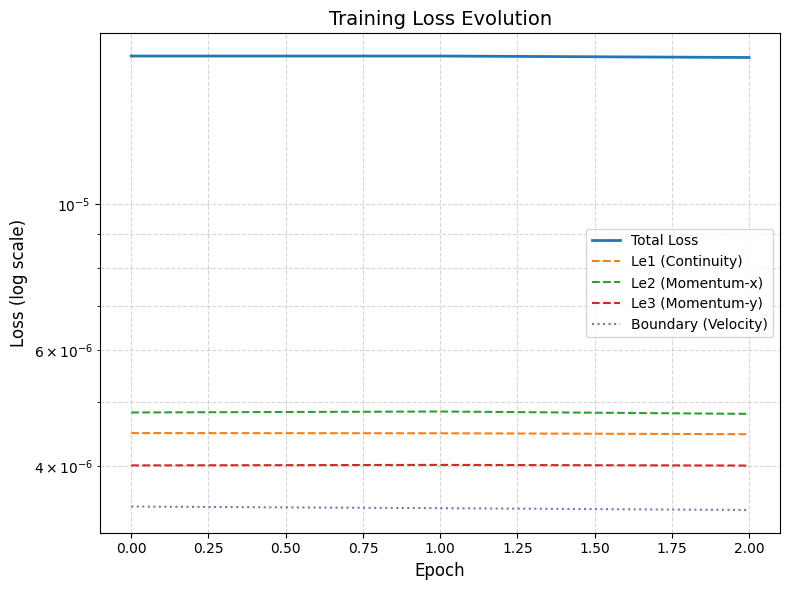

Saved loss history to 'loss_history.npz'


In [ ]:

# Plot loss curves
plt.figure(figsize=(8, 6))
plt.semilogy(loss_history["total"], label="Total Loss", linewidth=2)
plt.semilogy(loss_history["Le1"], '--', label="Le1 (Continuity)")
plt.semilogy(loss_history["Le2"], '--', label="Le2 (Momentum-x)")
plt.semilogy(loss_history["Le3"], '--', label="Le3 (Momentum-y)")
plt.semilogy(loss_history["Lbv"], ':', label="Boundary (Velocity)")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss (log scale)", fontsize=12)
plt.title("Training Loss Evolution", fontsize=14)
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Optionally: Save losses to file for later analysis
np.savez("loss_history.npz", **loss_history)
print("Saved loss history to 'loss_history.npz'")


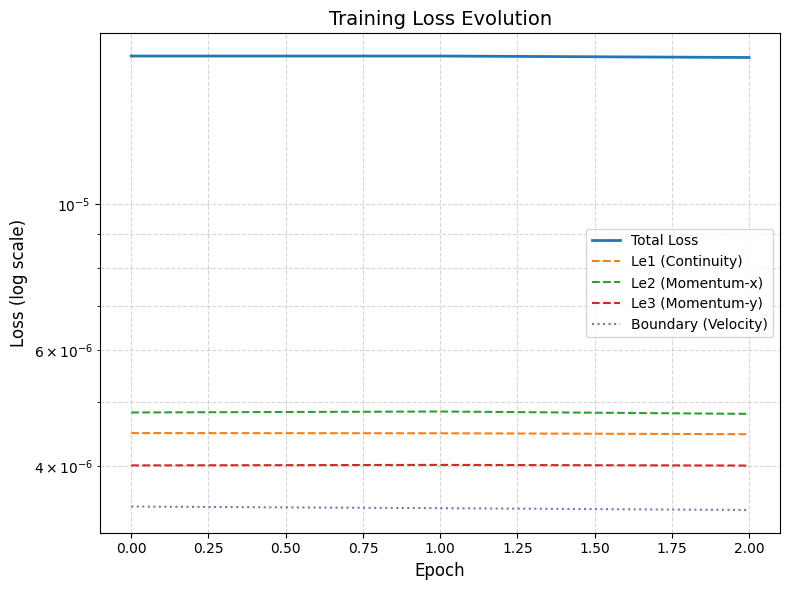

Saved loss history to 'loss_history.npz'


In [16]:
# =====================================================
# Plot loss curves
# =====================================================
plt.figure(figsize=(8, 6))
plt.semilogy(loss_history["total"], label="Total Loss", linewidth=2)
plt.semilogy(loss_history["Le1"], '--', label="Le1 (Continuity)")
plt.semilogy(loss_history["Le2"], '--', label="Le2 (Momentum-x)")
plt.semilogy(loss_history["Le3"], '--', label="Le3 (Momentum-y)")
plt.semilogy(loss_history["Lbv"], ':', label="Boundary (Velocity)")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss (log scale)", fontsize=12)
plt.title("Training Loss Evolution", fontsize=14)
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Optionally: Save losses to file for later analysis
np.savez("loss_history.npz", **loss_history)
print("Saved loss history to 'loss_history.npz'")


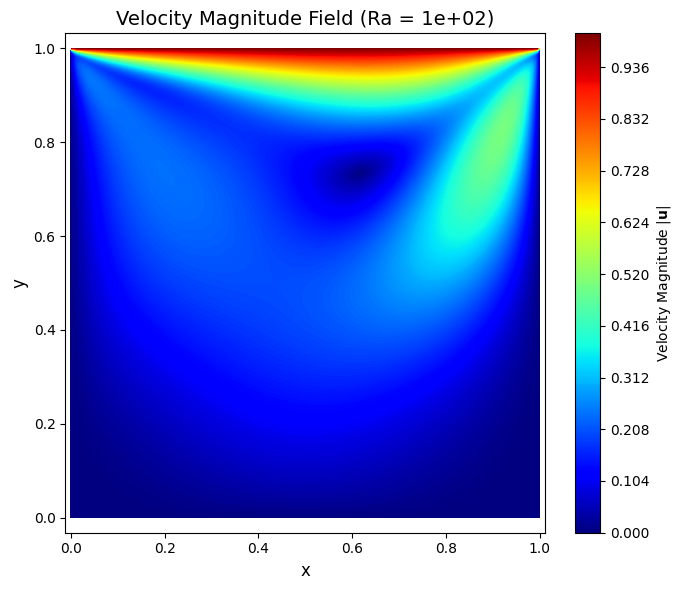

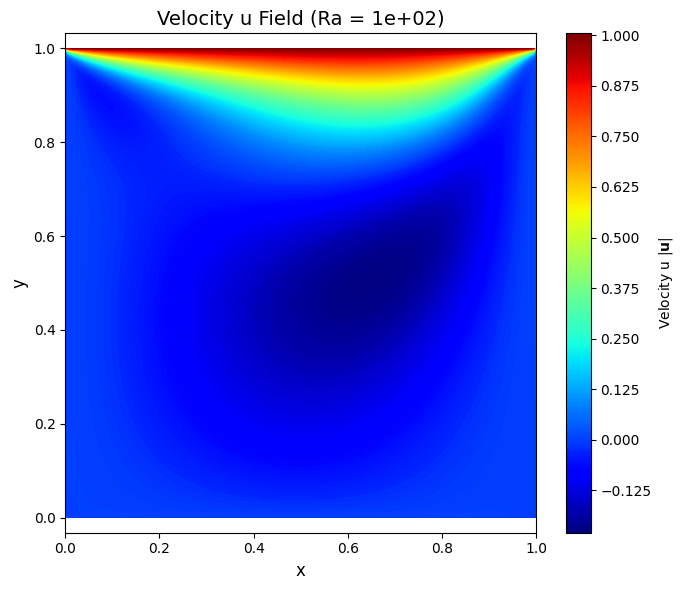

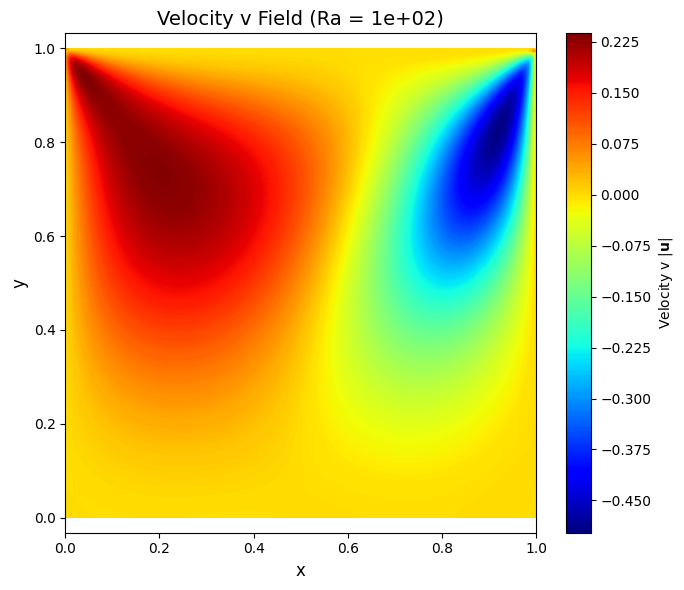

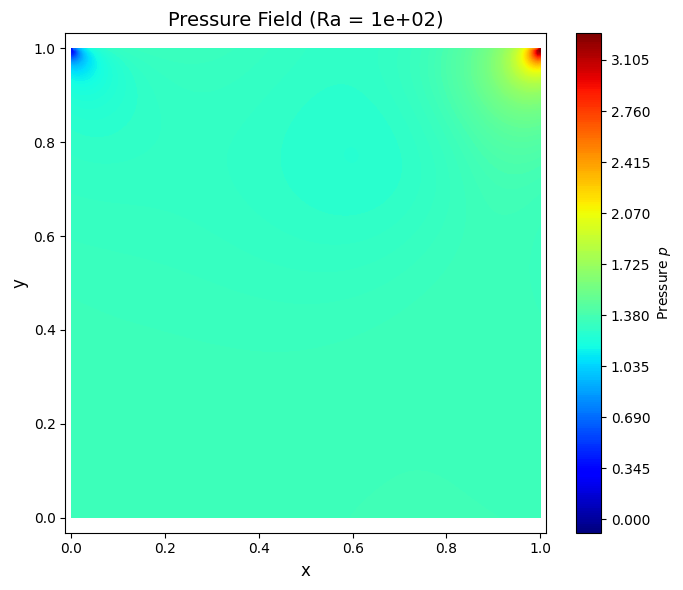

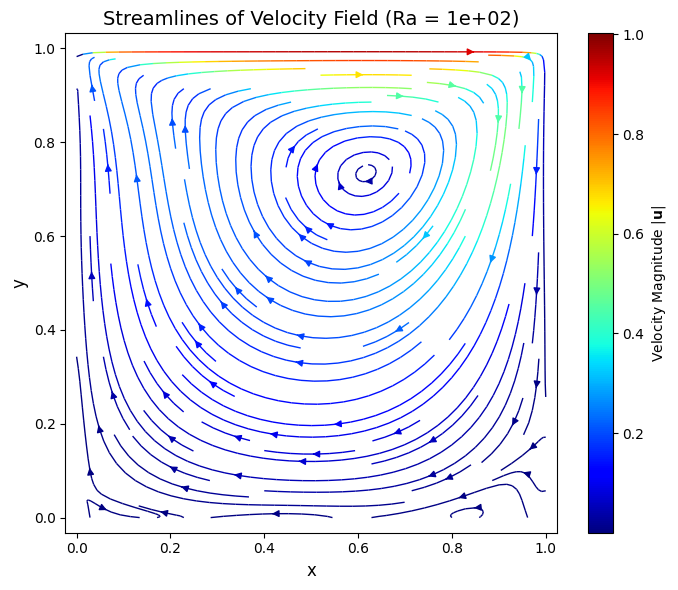

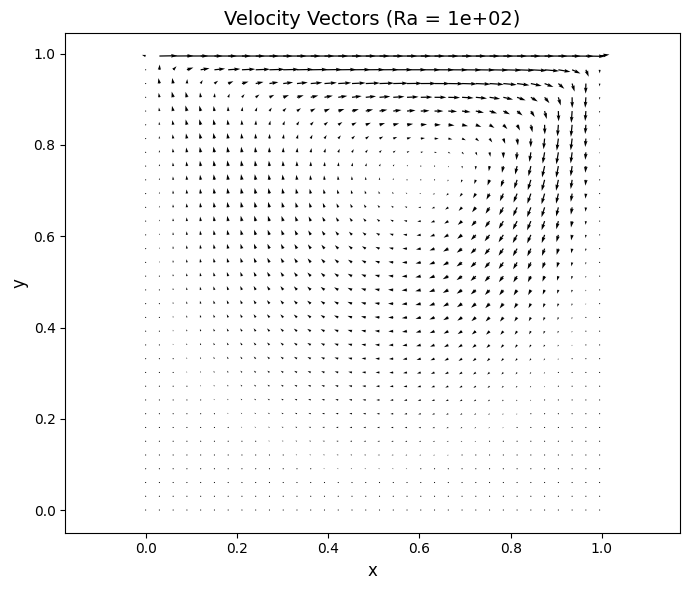

In [17]:
Nx, Ny = 200, 200   # grid resolution for plotting
x = np.linspace(0, 1, Nx)
y = np.linspace(0, 1, Ny)
X, Y = np.meshgrid(x, y)

# Choose Rayleigh number for evaluation (can be fixed or changed)
Ra_plot = 1e2
Ra_val = np.full_like(X, Ra_plot)

# Stack grid points into (x, y, Ra) tensor
X_input = np.stack([X.flatten(), Y.flatten(), Ra_val.flatten()], axis=1)
X_tf = tf.convert_to_tensor(X_input, dtype=tf.float32)

# =====================================================
# Evaluate model outputs (u, v, theta, p)
# =====================================================
u_pred, v_pred, p_pred = model(X_tf)
u_pred = u_pred.numpy().reshape(Ny, Nx)
v_pred = v_pred.numpy().reshape(Ny, Nx)
p_pred = p_pred.numpy().reshape(Ny, Nx)

# Compute velocity magnitude for visualization
vel_mag = np.sqrt(u_pred**2 + v_pred**2)

# =====================================================
# Velocity magnitude contour plot
# =====================================================
plt.figure(figsize=(7, 6))
contour = plt.contourf(X, Y, vel_mag, levels=300, cmap='jet')
plt.colorbar(contour, label=r"Velocity Magnitude $|\mathbf{u}|$")
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.title(f"Velocity Magnitude Field (Ra = {Ra_plot:.0e})", fontsize=14)
plt.axis("equal")
plt.tight_layout()
plt.show()

# =====================================================
# Velocity u contour plot
# =====================================================
plt.figure(figsize=(7, 6))
contour = plt.contourf(X, Y, u_pred, levels=300, cmap='jet')
plt.colorbar(contour, label=r"Velocity u $|\mathbf{u}|$")
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.title(f"Velocity u Field (Ra = {Ra_plot:.0e})", fontsize=14)
plt.axis("equal")
plt.tight_layout()
plt.show()
# =====================================================
# Velocity v contour plot
# =====================================================
plt.figure(figsize=(7, 6))
contour = plt.contourf(X, Y, v_pred, levels=300, cmap='jet')
plt.colorbar(contour, label=r"Velocity v $|\mathbf{u}|$")
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.title(f"Velocity v Field (Ra = {Ra_plot:.0e})", fontsize=14)
plt.axis("equal")
plt.tight_layout()
plt.show()
# =====================================================
# Pressure contour plot
# =====================================================
plt.figure(figsize=(7, 6))
contour = plt.contourf(X, Y, p_pred, levels=300, cmap='jet')
plt.colorbar(contour, label="Pressure $p$")
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.title(f"Pressure Field (Ra = {Ra_plot:.0e})", fontsize=14)
plt.axis("equal")
plt.tight_layout()
plt.show()

# =====================================================
# Streamline plot (velocity field)
# =====================================================
plt.figure(figsize=(7, 6))
plt.streamplot(X, Y, u_pred, v_pred, color=vel_mag, cmap='jet', density=1.2, linewidth=1)
plt.colorbar(label=r"Velocity Magnitude $|\mathbf{u}|$")
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.title(f"Streamlines of Velocity Field (Ra = {Ra_plot:.0e})", fontsize=14)
plt.axis("equal")
plt.tight_layout()
plt.show()

# =====================================================
# Vector (quiver) plot of velocity field
# =====================================================
plt.figure(figsize=(7, 6))
skip = (slice(None, None, 6), slice(None, None, 6))  # downsample for clarity
plt.quiver(X[skip], Y[skip], u_pred[skip], v_pred[skip],
           color='black', scale=25, width=0.002)
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.title(f"Velocity Vectors (Ra = {Ra_plot:.0e})", fontsize=14)
plt.axis("equal")
plt.tight_layout()
plt.show()
